# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

### Alejandro Somarriba Aguirre - A01751277

Nota: la sección para realizar predicciones de cartas nuevas está hasta abajo.

## Introducción

El problema a resolver con este proyecto es la identificación de cartas de jugar mediante un modelo de aprendizaje profundo hecho con una red neuronal convolutiva. En una baraja regular de cartas hay 54 cartas, divididas en 13 cartas de 4 palos diferentes, y 2 Jokers. En un contexto como algún casino, puede ser importante ser capaz de identificar las cartas que se juegan en un juego, ya que puede prevenir que haya trampa de algún tipo.<br>
El dataset que se utilizó para el modelo fue obtenido de Kaggle (https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification) son imágenes de cartas de jugar, con aproximadamente 120 imágenes por cada carta diferente.

## Datos

Los datos de Kaggle ya estaban divididos en conjuntos de entrenamiento, validación y prueba, pero debido a que en los conjuntos de validación y prueba solamente había 5 imágenes por cada carta, se decidió juntar todos los conjuntos y separarlos manualmente, ya que se consideró que sería muy pocas imágenes de validación y prueba.

Se comienza importando las librerías necesarias y obteniendo los datos desde Kaggle:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import files
from keras import layers

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/cards-image-datasetclassification
!unzip cards-image-datasetclassification.zip

%matplotlib inline

Para mantener transparencia, es importante mencionar que en la liga de Kaggle también se encuentran 2 modelos pre-entrenados que realizan la tarea de clasificar las imágenes. Para este proyecto, solamente se utilizan las imágenes de las cartas; en ningún momento se usan los modelo pre-entrenados.

Además de las imágenes, en los datos de Kaggle también había un archivo .csv en el que venía un desglose de los directorios de todas las imágenes, al igual que su clase y el tipo de carta que era. A continuación se lee dicho archivo en un DataFrame y se le hace una ligera limpieza para eliminar una fila sobrante y para cambiar los valores de "xxx" a "joker" en la columna "card type". Del mismo modo, se añadió otra columna en la que se indica el palo de la carta.

In [ ]:
cards = pd.read_csv("cards.csv")

cards["card type"].replace("xxx", "joker", inplace=True)
cards["suit"] = cards["labels"].map(lambda x : x if x == "joker" else x[x.index("of")+3:])
cards.drop(120, inplace=True)
cards.reset_index(inplace=True, drop=True)

cards.head()

class index                   filepaths        labels card type data set  \
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train   
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train   
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train   
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train   
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train   

    suit  
0  clubs  
1  clubs  
2  clubs  
3  clubs  
4  clubs

Luego, para facilitar el manejo de los datos, se añadió otra columna al DataFrame, en la que se guardan las imágenes de todas las cartas.

In [ ]:
img_list = []

for path in cards["filepaths"]:
  im_temp = np.array(Image.open(path))
  img_list.append(im_temp)

cards["image"] = pd.DataFrame({"image":img_list})
cards.head()

class index                   filepaths        labels card type data set  \
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train   
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train   
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train   
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train   
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train   

    suit                                              image  
0  clubs  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  clubs  [[[248, 248, 246], [251, 251, 249], [249, 249,...  
2  clubs  [[[0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0], ...  
3  clubs  [[[252, 255, 255], [252, 255, 255], [252, 252,...  
4  clubs  [[[254, 255, 253], [253, 255, 250], [253, 254,...

Por si acaso, se guarda el DataFrame como un archivo .csv<br>
(Para la segunda entrega se hizo la observación de que el archivo .csv no guarda las imágenes bien, así que no se termina usando...)

In [ ]:
# cards.to_csv("cards_clean.csv", index=False)

A continuación, se muestra una carta desde el DataFrame para probar que se guardaron bien.

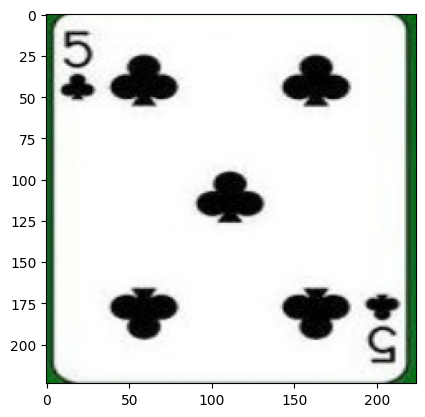

In [ ]:
plt.imshow(cards["image"][1234])

## Modelos

A continuación, se hacen 3 modelos diferentes; uno para la clasificación de las 53 cartas diferentes, uno para la clasificación de los 4 palos (y el joker), y uno para la clasificación de los 13 números (y joker).<br>
Después de los modelos y los resultados, hay una sección donde se pueden correr las celdas para realizar diferentes clasificaciones.

### Modelo de Todas las cartas

Se hace la separación de los datos de entrenamiento y prueba (la parte de validación se hace más adelante al ajustar el modelo). En la función <code>train_test_split</code>, se indica el parámetro <code>stratify</code> para asegurar que al dividir los datos, las clases no queden desbalanceadas. Se decidió hacer una división de 80% para entrenamiento y 20% para prueba porque se consideró que para 53 clases no se tenían muchas imágenes, por lo que se le quiere a dar más datos al entrenamiento.

In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(cards["image"], cards["class index"], test_size=0.2, stratify=cards["class index"])

Se puede verificar que los conjuntos no quedaron con clases desbalanceadas mostrando un histograma de las clases

<Axes: >

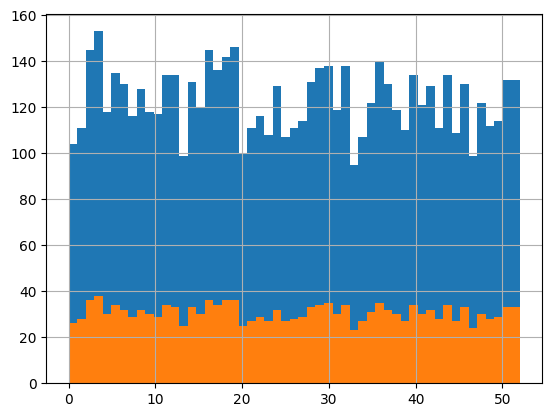

In [ ]:
y_train_all.hist(bins=53)
y_test_all.hist(bins=53)

Se puede observar que están decentemente distribuidas

Debido a que la librería para el modelo utiliza arreglos de NumPy, se transforman los conjuntos de datos en arreglos de NumPy

In [ ]:
X_train_all2 = np.array(X_train_all.to_list())
X_test_all2 = np.array(X_test_all.to_list())
y_train_all2 = np.array(y_train_all)
y_test_all2 = np.array(y_test_all)

#### Desarrollo del modelo

A continuación se comienza a desarrollar la red neuronal, utilizando la librería de Keras.

Para el primer modelo, después de la capa de entrada, se añade una capa para escalar los datos para que tengan valores entre 0 y 1. Después, se añaden 6 capas de convolución con diferentes números de filtros seguidas de capas de pooling. Al final, se añade una capa para aplanar las imágenes en un vector unidimensional para que pueda pasar a una capa densa con 53 neuronas (1 por cada clase) con activación Softmax.

In [ ]:
model_all1 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(53, activation="softmax")])

model_all1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

Se utiliza la métrica de pérdida de <code>sparse_categorical_crossentropy</code> porque se trata de un problema de clasificación con varias clases. El optimizador se colocó como <code>adam</code> porque generalmente da buenos resultados. Finalmente, se incluye la métrica de <code>accuracy</code> para ver en general cuántas observaciones fueron clasificadas correctamente.

In [ ]:
model_all1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

A continuación, se ajusta el modelo con los datos de entrenamiento. Se indica que entrene por 10 épocas y que reserve el 10% de los datos de entrenamiento para validación.

In [ ]:
history_all1 = model_all1.fit(X_train_all2, y_train_all2, epochs=10, validation_split=0.1)

Epoch 1/10
184/184 [==============================] - 17s 57ms/step - loss: 3.3698 - accuracy: 0.1189 - val_loss: 2.5891 - val_accuracy: 0.2757
Epoch 2/10
184/184 [==============================] - 9s 50ms/step - loss: 2.0215 - accuracy: 0.4206 - val_loss: 1.8022 - val_accuracy: 0.5023
Epoch 3/10
184/184 [==============================] - 9s 51ms/step - loss: 1.3931 - accuracy: 0.6203 - val_loss: 1.6146 - val_accuracy: 0.5926
Epoch 4/10
184/184 [==============================] - 9s 51ms/step - loss: 1.0005 - accuracy: 0.7210 - val_loss: 1.6653 - val_accuracy: 0.6279
Epoch 5/10
184/184 [==============================] - 9s 50ms/step - loss: 0.7184 - accuracy: 0.7935 - val_loss: 1.6167 - val_accuracy: 0.6508
Epoch 6/10
184/184 [==============================] - 9s 50ms/step - loss: 0.4971 - accuracy: 0.8589 - val_loss: 1.9169 - val_accuracy: 0.6493
Epoch 7/10
184/184 [==============================] - 9s 49ms/step - loss: 0.3274 - accuracy: 0.9094 - val_loss: 1.9741 - val_accuracy: 0.657

Una vez que se termina de entrenar el modelo, se muestran gráficas de cómo fue cambiando la pérdida y el accuracy con cada época.

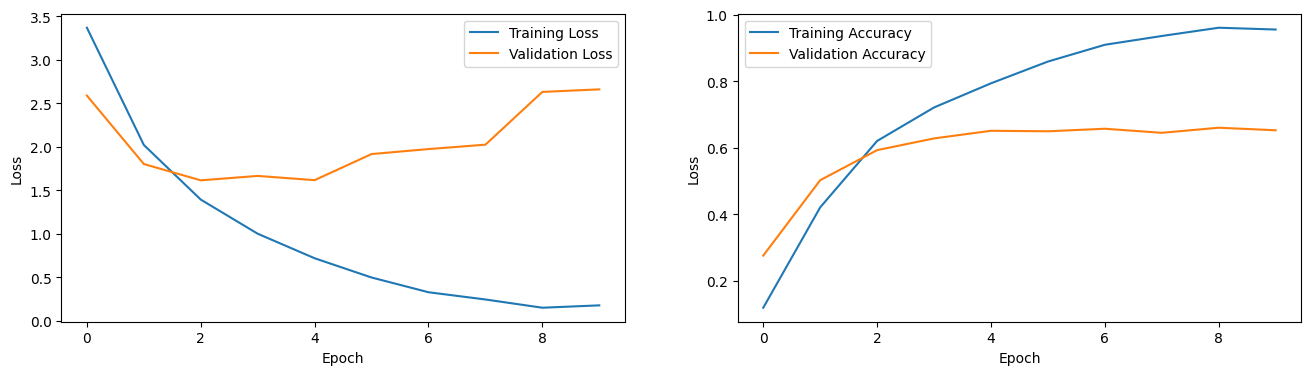

In [ ]:
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_all1.history['loss'], label='Training Loss')
plt.plot(history_all1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_all1.history['accuracy'], label='Training Accuracy')
plt.plot(history_all1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Se puede observar que este primer modelo sufre mucho de overfitting, es decir, se aprende bastante bien los datos de entrenamiento, pero cuando es presentado con datos que no ha visto, le cuesta trabajo clasificarlos correctamente. Esto es evidente en la gráfica de la derecha, en la que se puede ver que el valor de accuracy para los datos de validación queda muy por debajo del valor de accuracy para los datos de entrenamiento.<br>
Del mismo modo, para la pérdida del modelo, observada en la gráfica de la izquierda, se puede ver que para los datos de entrenamiento llega a ser bastante baja. Sin embargo, para los datos de validación, la pérdida llega a aumentar con el tiempo.

A continuación, se evalúa este modelo con los datos de prueba.

In [ ]:
loss_all1, accuracy_all1 = model_all1.evaluate(X_test_all2, y_test_all2)
print("Loss:", loss_all1)
print("Accuracy:", accuracy_all1)

51/51 [==============================] - 1s 25ms/step - loss: 2.4430 - accuracy: 0.6849
Loss: 2.443010091781616
Accuracy: 0.6848559379577637


Parece ser que los resultados obtenidos con los datos prueba son consistentes con los datos de validación. Esto confirma que el modelo está sobreajustado a los datos de entrenamiento y que no es capaz de generalizar para imágenes que no ha visto antes.

Se guarda el modelo.

In [ ]:
# model_all1.save("model_all1.keras")

#### Ajuste del modelo

A partir de los resultados obtenidos con el primer modelo, se hacen las siguientes modificaciones para tratar de mejorar su desempeño. Dado que el modelo sufre mucho de overfitting, se tratará de utilizar la técnica de Data Augmentation, alterando ligeramente las imágenes de entrada para que tenga más imágenes con las cuales puede aprender. Se crea una capa en la que se les da una rotación aleatoria a las imágenes.

In [ ]:
data_augmentation = keras.Sequential([layers.RandomRotation(0.5, fill_mode="constant", fill_value=0.0)], name='data_augmentation')

Según las correcciones a la primera entrega, se coloca 1 de estas capas al principio de la red. Adicionalmente, también se añaden capas de BatchNormalization para ver si mejora el desempeño del modelo. Al final, se añade una capa de Dropout, con una tasa de 0.1, de manera que al final de la red se apagan 10% de las neuronas, obligando al modelo a aprender de otra forma; esto debería hacer que el modelo sea más robusto. También se aumenta el número de de filtros de las primeras capas de convolución.

In [ ]:
model_all2 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Dropout(0.1),
                          layers.Flatten(),
                          layers.Dense(53, activation="softmax")])

model_all2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                        

Nuevamente se compila el modelo con los mismos parámetros que el primero

In [ ]:
model_all2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Sin embargo, a diferencia del primero, a este modelo se le deja correr por 30 épocas, bajo el supuesto de que ya no va a ocurrir tanto overfitting, y por lo tanto debería de poder aprender más.

In [ ]:
history_all2 = model_all2.fit(X_train_all2, y_train_all2, epochs=30, validation_split=0.1)

Epoch 1/30
184/184 [==============================] - 73s 245ms/step - loss: 3.1527 - accuracy: 0.1734 - val_loss: 4.1533 - val_accuracy: 0.0337
Epoch 2/30
184/184 [==============================] - 43s 236ms/step - loss: 2.6043 - accuracy: 0.2622 - val_loss: 3.1488 - val_accuracy: 0.1761
Epoch 3/30
184/184 [==============================] - 43s 236ms/step - loss: 2.3946 - accuracy: 0.2978 - val_loss: 2.4508 - val_accuracy: 0.2833
Epoch 4/30
184/184 [==============================] - 43s 235ms/step - loss: 2.2710 - accuracy: 0.3378 - val_loss: 2.4007 - val_accuracy: 0.2925
Epoch 5/30
184/184 [==============================] - 43s 235ms/step - loss: 2.1436 - accuracy: 0.3639 - val_loss: 2.2108 - val_accuracy: 0.3614
Epoch 6/30
184/184 [==============================] - 43s 231ms/step - loss: 2.0399 - accuracy: 0.4063 - val_loss: 2.8204 - val_accuracy: 0.2573
Epoch 7/30
184/184 [==============================] - 42s 230ms/step - loss: 1.9573 - accuracy: 0.4422 - val_loss: 2.1173 - val_ac

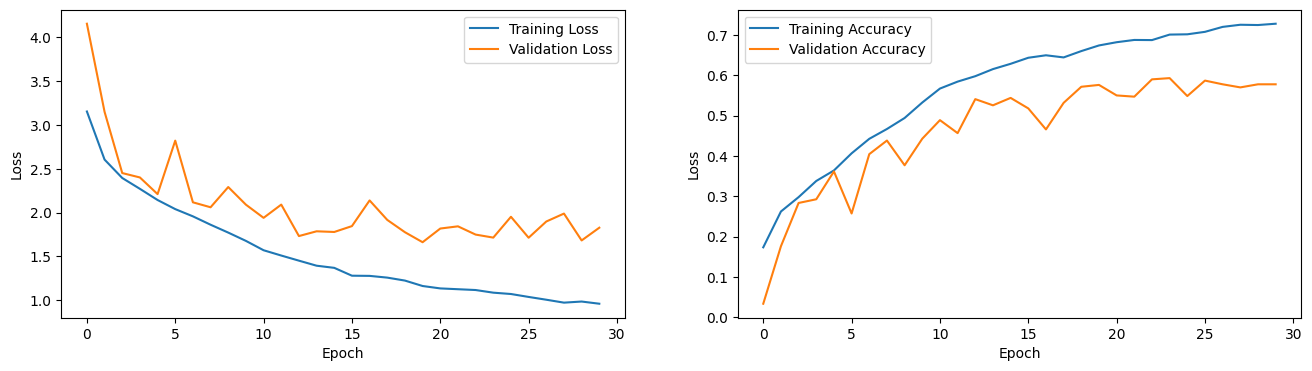

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_all2.history['loss'], label='Training Loss')
plt.plot(history_all2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_all2.history['accuracy'], label='Training Accuracy')
plt.plot(history_all2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Con este nuevo modelo, se puede observar que el grado de overfitting ha disminuido significantemente, ya que los valores de accuracy están más cercanos que en el modelo anterior (esto se visualiza en la gráfica derecha). Esto indica que los ajustes realizados al modelo tuvieron un efecto positivo en el desempeño del mismo. Desafortunadamente, a pesar de que se logró cerrar bastante la brecha entre el accuracy de los datos de entrenamiento y los datos de validación, el accuracy en general no es muy bueno, y ambos valores de accuracy (tanto de entrenamiento y de validación) disminuyeron con respecto al primer modelo. Esto podría deberse a la cantidad de clases y la cantidad de imágenes para cada clase.<br>
Por otro lado, en la gráfica izquierda se puede apreciar que el valor de pérdida para los datos de validación disminuyó considerablemente en comparación a los datos de entrenamiento. Esto indica que el modelo ha mejorado de cierta manera.

Igual que el modelo principal, se evalúa el modelo modificado.

In [ ]:
loss_all2, accuracy_all2 = model_all2.evaluate(X_test_all2, y_test_all2)
print("Loss:", loss_all2)
print("Accuracy:", accuracy_all2)

51/51 [==============================] - 2s 48ms/step - loss: 1.6124 - accuracy: 0.6156
Loss: 1.6123989820480347
Accuracy: 0.6155732870101929


Parece ser que el segundo modelo no es muy bueno, ya que los resultados de accuracy en la evaluación con los datos de prueba son peores que los obtenidos para el primer modelo. Sin embargo, en la métrica de pérdida se percibe una mejora significativa con los datos de prueba.<br>
También se guarda el modelo modificado.

In [ ]:
# model_all2.save("modelo_all2.keras")

#### Predicciones de cartas

(Se usa el <b>segundo</b> modelo para realizar las predicciones)

Simplemente por probar, se predice el tipo de una carta al azar:

In [ ]:
# Esto simplemente genera una lista de las clases con sus índices numéricos correspondientes
labels_all = [(idc, cards[cards["class index"] == idc]["labels"].head(1).values[0]) for idc in range(53)]

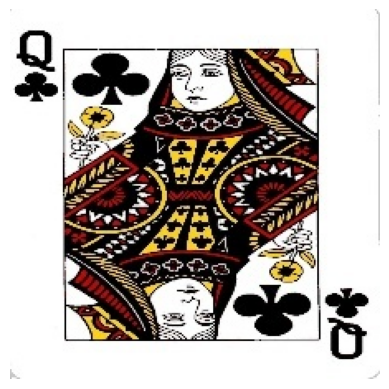

In [ ]:
random_inx = np.random.choice(X_test_all2.shape[0])
test_image = X_test_all2[random_inx]

plt.axis('off')
plt.imshow(test_image)
plt.show()

In [ ]:
pred_all = model_all2.predict(test_image[np.newaxis,...])
print("Model: ", labels_all[np.argmax(pred_all)])

1/1 [==============================] - 0s 19ms/step
Model:  (29, 'queen of clubs')


Después de haber corrido las 2 celdas anteriores un par de veces, parece ser que el modelo tiene más problemas con cartas que están muy estilizadas, porque para cartas que se ven "normales", no aparenta haber mucho problema.

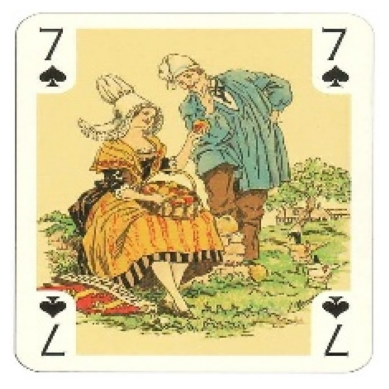

In [ ]:
random_inx = np.random.choice(X_test_all2.shape[0])
test_image = X_test_all2[random_inx]

plt.axis('off')
plt.imshow(test_image)
plt.show()

In [ ]:
pred_all = model_all2.predict(test_image[np.newaxis,...])
print("Model: ", labels_all[np.argmax(pred_all)])

1/1 [==============================] - 0s 19ms/step
Model:  (22, 'king of diamonds')


La carta anterior es un muy bueno ejemplo de cómo se puede confundir el modelo; la carta es un 7 de espadas, pero tiene una ilustración con personas. Dado que generalmente las únicas cartas con ilustraciones con personas son las de los reyes, reinas y jotas, es probable que el modelo haya aprendido esta característica y por eso ahora confunde la carta con un rey de diamantes.

### Modelo de Palos

Para el modelo de clasificación de los palos, se simplifica el problema, ya que solamente hay 5 clases posibles. Esto significa que con el dataset original se tienen más datos de entrenamiento, ya que hay más observaciones para menos clases.<br>
Igual que para los modelos de todas las cartas, se hace la separación de los datos de entrenamiento y prueba. Se sigue el mismo proceso.

In [ ]:
X_train_suit, X_test_suit, y_train_suit, y_test_suit = train_test_split(cards["image"], cards["suit"], test_size=0.2, stratify=cards["class index"])

Se muestra una histograma de las clases para verificar la distribución

<Axes: >

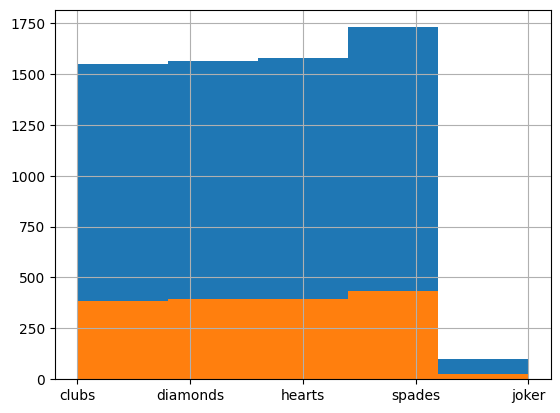

In [ ]:
y_train_suit.hist(bins=5)
y_test_suit.hist(bins=5)

Igual que para los modelos anteriores, se puede observar que están decentemente distribuidas

Para el modelo de clasificación de todas las cartas, el archivo .csv ya incluía un índice para cada carta en la columna "class index". Para el problema de clasificación de solamente los palos, no existe tal índice numérico; para eso es la siguiente celda. Es un diccionario en el que se especifica la relación de cada clase con un número.

In [ ]:
suit_dict = {"joker": 0,
             "clubs": 1,
             "hearts": 2,
             "spades": 3,
             "diamonds": 4}

Igual que en los modelos anteriores, se hace una transformación a arreglos de NumPy.

In [ ]:
y_train_suit = y_train_suit.map(lambda x : suit_dict[x])
y_test_suit = y_test_suit.map(lambda x : suit_dict[x])

X_train_suit2 = np.array(X_train_suit.to_list())
X_test_suit2 = np.array(X_test_suit.to_list())
y_train_suit2 = np.array(y_train_suit)
y_test_suit2 = np.array(y_test_suit)

#### Desarrollo del modelo

A continuación se comienza a desarrollar la red neuronal, utilizando la librería de Keras.

Por experimentar, se mantiene la misma estructura de la primera red utilizada para el modelo de todas las cartas; lo único que cambia es la cantidad de neuronas en la capa densa a 5 neuronas, ya que solamente se tienen 5 clases.

In [ ]:
model_suit1 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(5, activation="softmax")])

model_suit1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)       7

De igual forma, los hiperparámetros del compilador se mantienen iguales para este nuevo modelo.

In [ ]:
model_suit1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

A continuación, se ajusta el modelo con los datos de entrenamiento. Se indica que entrene por 10 épocas y que reserve el 10% de los datos de entrenamiento para validación.

In [ ]:
history_suit1 = model_suit1.fit(X_train_suit2, y_train_suit2, epochs=10, validation_split=0.1)

Epoch 1/10
184/184 [==============================] - 17s 59ms/step - loss: 1.2120 - accuracy: 0.3961 - val_loss: 1.0203 - val_accuracy: 0.5850
Epoch 2/10
184/184 [==============================] - 9s 50ms/step - loss: 0.5773 - accuracy: 0.7729 - val_loss: 0.4095 - val_accuracy: 0.8331
Epoch 3/10
184/184 [==============================] - 10s 55ms/step - loss: 0.3222 - accuracy: 0.8813 - val_loss: 0.3123 - val_accuracy: 0.8821
Epoch 4/10
184/184 [==============================] - 9s 50ms/step - loss: 0.2156 - accuracy: 0.9233 - val_loss: 0.2692 - val_accuracy: 0.8959
Epoch 5/10
184/184 [==============================] - 9s 50ms/step - loss: 0.1406 - accuracy: 0.9535 - val_loss: 0.3013 - val_accuracy: 0.9051
Epoch 6/10
184/184 [==============================] - 9s 52ms/step - loss: 0.1052 - accuracy: 0.9695 - val_loss: 0.2194 - val_accuracy: 0.9357
Epoch 7/10
184/184 [==============================] - 9s 51ms/step - loss: 0.0930 - accuracy: 0.9719 - val_loss: 0.2007 - val_accuracy: 0.93

Una vez que se termina de entrenar el modelo, se muestran gráficas de cómo fue cambiando la pérdida y el accuracy con cada época.

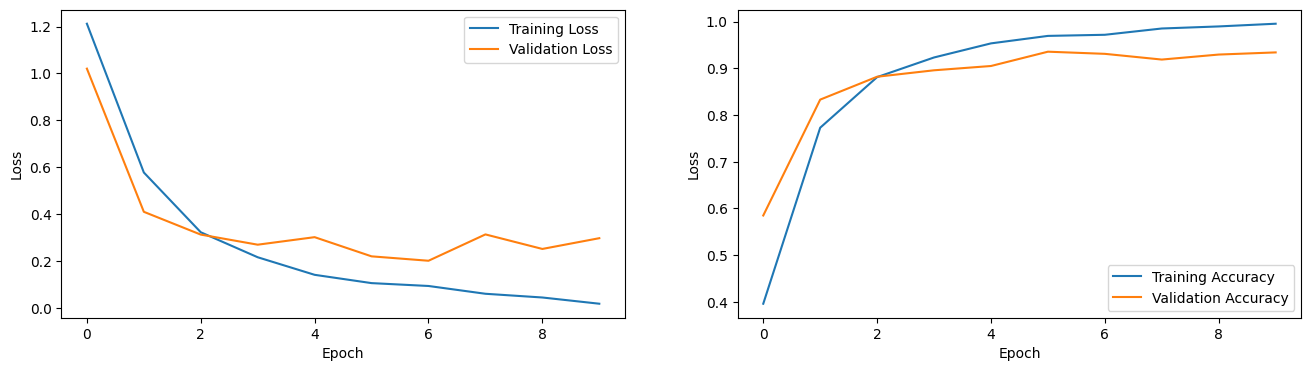

In [ ]:
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_suit1.history['loss'], label='Training Loss')
plt.plot(history_suit1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_suit1.history['accuracy'], label='Training Accuracy')
plt.plot(history_suit1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

A diferencia del modelo de todas las cartas, este modelo que solamente se enfoca en clasificar el palo de carta es mucho mejor, alcanzando puntajes de accuracy para entrenamiento y validación bastante altos. Se podría decir que hay un ligero overfitting, debido a que el accuracy de entrenamiento queda por encima del accuracy de validación, pero de todas formas parece ser decente.<br>
Por la parte de la pérdida, también se tienen buenos resultados; la línea de la pérdida de validación no se separa tanto de la línea de pérdida de entrenamiento, como fue el caso en el primer modelo de todas las cartas. Para ser la primera iteración del modelo, se puede decir que está bastante bien.

A continuación, se evalúa el modelo con los datos de prueba.

In [ ]:
loss_suit1, accuracy_suit1 = model_suit1.evaluate(X_test_suit2, y_test_suit2)
print("Loss:", loss_suit1)
print("Accuracy:", accuracy_suit1)

51/51 [==============================] - 1s 25ms/step - loss: 0.2494 - accuracy: 0.9485
Loss: 0.2493586391210556
Accuracy: 0.9484978318214417


Los resultados obtenidos con los datos prueba parecen ser consistentes con los datos de validación. Se tiene un valor de accuracy de casi 95% y una pérdida relativamente baja.

Se guarda el modelo.

In [ ]:
# model_suit1.save("model_suit1.keras")

#### Ajuste del modelo

A pesar de los buenos resultados del primer modelo, se hará el intento de mejorar incluso más. De igual forma se aplica Data Augmentation y otros cambios al modelo.

In [ ]:
data_augmentation = keras.Sequential([layers.RandomRotation(0.5, fill_mode="constant", fill_value=0.0)], name='data_augmentation')

A continuación se observan los cambios realizados al modelo. Se añadieron capas de batch normalization y al final una capa de Dropout, para que el modelo no dependa de una sola ruta para llegar a una clasificación en específico.

In [ ]:
model_suit2 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Dropout(0.1),
                          layers.Flatten(),
                          layers.Dense(5, activation="softmax")])

model_suit2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                      

Nuevamente se compila el modelo con los mismos parámetros que el primero

In [ ]:
model_suit2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Como al modelo modificado también usa Data Augmentation, se asume que se puede dejar entrenar por más épocas. También, considerando el desempeño del primer modelo, en vez de dejarlo por 30 épocas como el modelo de todas las cartas, se dejará solamente por 25 épocas.

In [ ]:
history_suit2 = model_suit2.fit(X_train_suit2, y_train_suit2, epochs=25, validation_split=0.1)

Epoch 1/25
184/184 [==============================] - 64s 126ms/step - loss: 1.3339 - accuracy: 0.4049 - val_loss: 1.4985 - val_accuracy: 0.3170
Epoch 2/25
184/184 [==============================] - 23s 124ms/step - loss: 1.1047 - accuracy: 0.4451 - val_loss: 1.0849 - val_accuracy: 0.4410
Epoch 3/25
184/184 [==============================] - 23s 125ms/step - loss: 1.0579 - accuracy: 0.4678 - val_loss: 1.0094 - val_accuracy: 0.4717
Epoch 4/25
184/184 [==============================] - 23s 125ms/step - loss: 1.0116 - accuracy: 0.4877 - val_loss: 0.9957 - val_accuracy: 0.5115
Epoch 5/25
184/184 [==============================] - 23s 124ms/step - loss: 0.9584 - accuracy: 0.5312 - val_loss: 0.9452 - val_accuracy: 0.5299
Epoch 6/25
184/184 [==============================] - 23s 125ms/step - loss: 0.8374 - accuracy: 0.6012 - val_loss: 0.7876 - val_accuracy: 0.6233
Epoch 7/25
184/184 [==============================] - 23s 123ms/step - loss: 0.7563 - accuracy: 0.6566 - val_loss: 0.7494 - val_ac

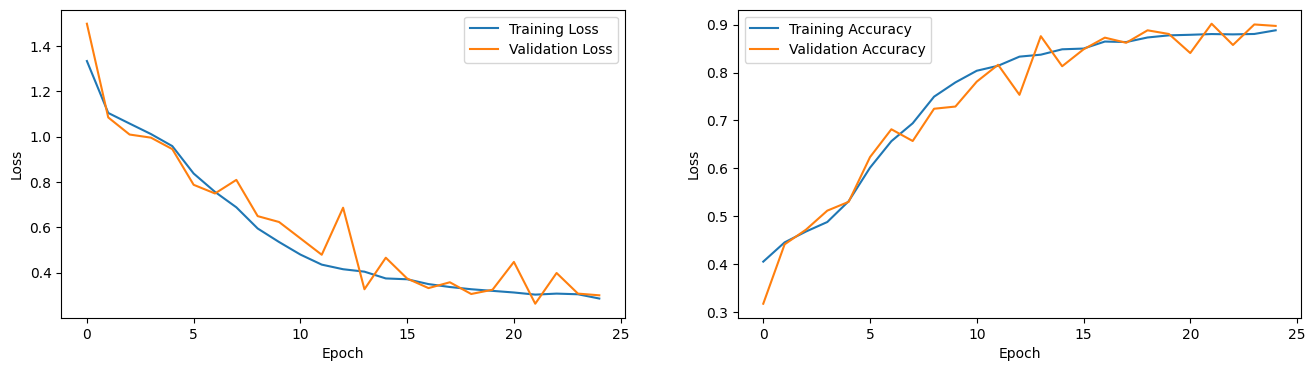

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_suit2.history['loss'], label='Training Loss')
plt.plot(history_suit2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_suit2.history['accuracy'], label='Training Accuracy')
plt.plot(history_suit2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Después de entrenar el nuevo modelo, se puede apreciar en las gráficas de accuracy y loss que el overfitting se ha reducido. Esto es algo errático, ya que se puede observar que los valores de validación fluctuan por arriba y abajo de los datos de entrenamiento. De todos modos, de manera general se ven bastante bien.<br>
Algo que sí vale la pena mencionar es que a pesar de que los valores de accuracy de validación y entrenamiento se parecen más, a comparación del primer modelo han disminuido un poco. De igual forma, para los valores de pérdida, aumentó para los datos de entrenamiento, y para los de validación se mantuvo algo constante.<br>
Se puede decir que es un mejor modelo porque se reduce el poco overfitting que había, pero no es mucho mejor porque las métricas no son igual de buenas.

Igual que el modelo principal, se evalúa el modelo modificado.

In [ ]:
loss_suit2, accuracy_suit2 = model_suit2.evaluate(X_test_suit2, y_test_suit2)
print("Loss:", loss_suit2)
print("Accuracy:", accuracy_suit2)

51/51 [==============================] - 1s 21ms/step - loss: 0.2551 - accuracy: 0.9007
Loss: 0.25511065125465393
Accuracy: 0.9006744623184204


Los resultados de ambos modelos de clasificación de palos de cartas son casi comparables, por lo que ahora se guarda el segundo modelo.

In [ ]:
# model_suit2.save("model_suit2.keras")

#### Predicciones de Palos

(Se usa el <b>primer</b> modelo para las predicciones de esta sección)

Se "invierte" el diccionario de las relaciones de números y palos.

In [ ]:
suit_labels = {}

for i in suit_dict:
  suit_labels[suit_dict[i]] = i

suit_labels

{0: 'joker', 1: 'clubs', 2: 'hearts', 3: 'spades', 4: 'diamonds'}

De igual forma que para las predicciones de las cartas individuales, se toman cartas aleatoriamente

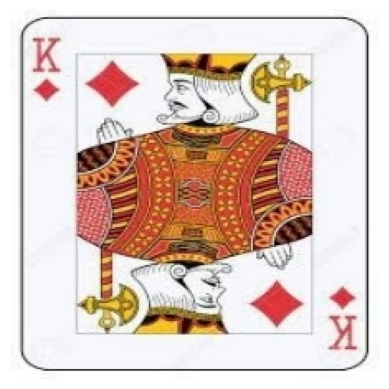

1/1 [==============================] - 0s 344ms/step
Suit Prediction:  diamonds 1.0
Suit True Label:  diamonds


In [ ]:
random_inx_suit = np.random.choice(X_test_suit.shape[0])
test_image_suit = X_test_suit2[random_inx_suit]
test_label_suit = y_test_suit2[random_inx_suit]

plt.axis('off')
plt.imshow(test_image_suit)
plt.show()

pred_suit = model_suit1.predict(test_image_suit[np.newaxis,...])
print("Suit Prediction: ", suit_labels[np.argmax(pred_suit)], pred_suit.max())
print("Suit True Label: ", suit_labels[test_label_suit])

Para esta primera clasificación, se logró correctamente con una probailidad de 1, lo que indica que el modelo aprendió bastante bien a identificar los diamantes.

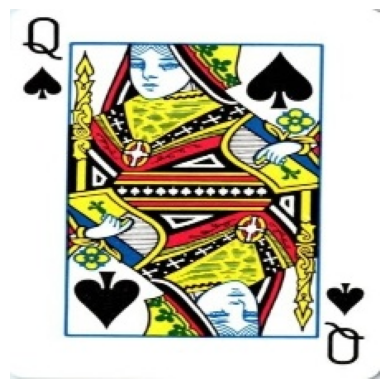

1/1 [==============================] - 0s 29ms/step
Suit Prediction:  spades 1.0
Suit True Label:  spades


In [ ]:
random_inx_suit = np.random.choice(X_test_suit.shape[0])
test_image_suit = X_test_suit2[random_inx_suit]
test_label_suit = y_test_suit2[random_inx_suit]

plt.axis('off')
plt.imshow(test_image_suit)
plt.show()

pred_suit = model_suit1.predict(test_image_suit[np.newaxis,...])
print("Suit Prediction: ", suit_labels[np.argmax(pred_suit)], pred_suit.max())
print("Suit True Label: ", suit_labels[test_label_suit])

Igual que en el ejemplo anterior, se hace la clasificación correcta con una probabilidad de 1.

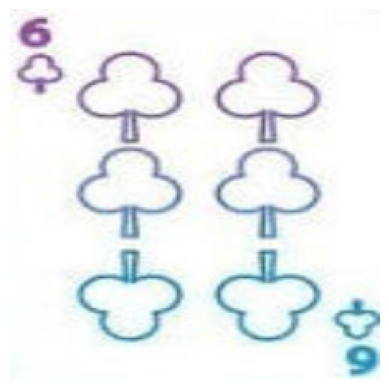

1/1 [==============================] - 0s 20ms/step
Suit Prediction:  spades 0.951745
Suit True Label:  spades


In [ ]:
random_inx_suit = np.random.choice(X_test_suit.shape[0])
test_image_suit = X_test_suit2[random_inx_suit]
test_label_suit = y_test_suit2[random_inx_suit]

plt.axis('off')
plt.imshow(test_image_suit)
plt.show()

pred_suit = model_suit1.predict(test_image_suit[np.newaxis,...])
print("Suit Prediction: ", suit_labels[np.argmax(pred_suit)], pred_suit.max())
print("Suit True Label: ", suit_labels[test_label_suit])

Este ejemplo es curioso, ya que sí logra clasificar correctamente el palo según el label original con una alta probabilidad, pero yo como humano hubiera pensado que el label correcto sería "clubs". Esto ahora se vuelve una cuestión de si la carta está muy estilizada o si algunas pocas cartas están accidentalmente en las carpetas incorrectas.<br>
Al probar la parte de la predicción, me encontré una carta que era claramente un 2 de diamantes negro y el modelo lo clasificó como "diamonds", pero el label original le correspondía a "spades"; busqué la carta en las carpeta de "two of spades" y ahí estaba. Esto me hace pensar que algunas cartas se colaron en la carpeta incorrecta...

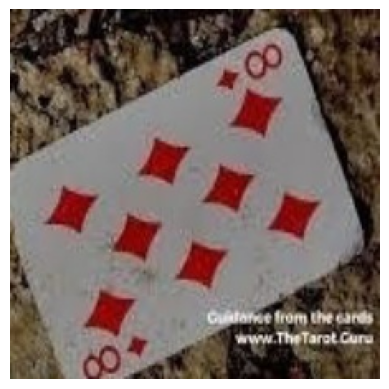

1/1 [==============================] - 0s 20ms/step
Suit Prediction:  hearts 0.74248517
Suit True Label:  diamonds


In [ ]:
random_inx_suit = np.random.choice(X_test_suit.shape[0])
test_image_suit = X_test_suit2[random_inx_suit]
test_label_suit = y_test_suit2[random_inx_suit]

plt.axis('off')
plt.imshow(test_image_suit)
plt.show()

pred_suit = model_suit1.predict(test_image_suit[np.newaxis,...])
print("Suit Prediction: ", suit_labels[np.argmax(pred_suit)], pred_suit.max())
print("Suit True Label: ", suit_labels[test_label_suit])

Después de realizar varias pruebas, me encontré con esta carta mal clasificada. La probabilidad de "hearts" es relativamente alta, lo que me hace pensar que el modelo tal vez no aprendió a identificar los palos de cartas que tienen rotación. Esto se podría arreglar con Data Augmentation, asegurando que se tengan muchas más cartas con rotación a la hora de entrenar el modelo. (Como estas predicciones se realizaron con el primer modelo, todavía no se había colocado la parte del Data Augmentation)

En general, las clasificaciones de palos son muy buenas, salvo por algunos pocos casos extraños.

### Modelo de Números

Finalmente, se hace un modelo para la clasificación de los números de las cartas. Se sigue el mismo proceso para separar los datos en entrenamiento y prueba. En este caso hay 14 clases (1 por cada número desde el As hasta el Rey, y el Joker)

In [ ]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(cards["image"], cards["card type"], test_size=0.2, stratify=cards["card type"])

Histogramas para ver distribución de clases (14 clases)

<Axes: >

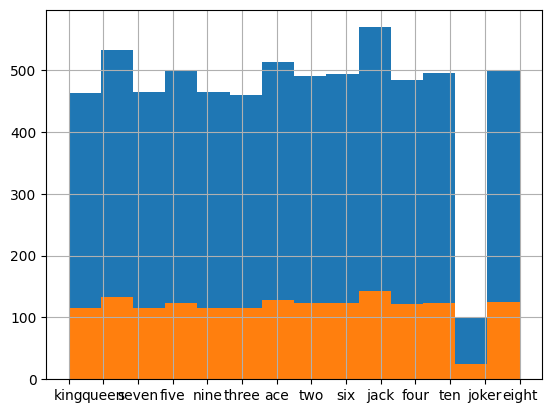

In [ ]:
y_train_ns.hist(bins=14)
y_test_ns.hist(bins=14)

Se puede observar que están decentemente distribuidas

Nuevamente, se tiene un diccionario para relacionar las cartas con un número.

In [ ]:
card_type_dict = {"joker": 0,
                  "ace": 1,
                  "two": 2,
                  "three": 3,
                  "four": 4,
                  "five": 5,
                  "six": 6,
                  "seven": 7,
                  "eight": 8,
                  "nine": 9,
                  "ten": 10,
                  "jack": 11,
                  "queen": 12,
                  "king": 13}

Transformación a arreglos de NumPy

In [ ]:
y_train_ns = y_train_ns.map(lambda x : card_type_dict[x])
y_test_ns = y_test_ns.map(lambda x : card_type_dict[x])

X_train_ns2 = np.array(X_train_ns.to_list())
X_test_ns2 = np.array(X_test_ns.to_list())
y_train_ns2 = np.array(y_train_ns)
y_test_ns2 = np.array(y_test_ns)

#### Desarrollo del modelo

A continuación se comienza a desarrollar la red neuronal, utilizando la librería de Keras.

Como en los modelos anteriores, la primera iteración del modelo usa la misma arquitectura.

In [ ]:
model_nums1 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Flatten(),
                          layers.Dense(14, activation="softmax")])

model_nums1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)      

El compilador sigue siendo el mismo que en los otros modelos.

In [ ]:
model_nums1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

A continuación, se ajusta el modelo con los datos de entrenamiento. Se indica que entrene por 10 épocas y que reserve el 10% de los datos de entrenamiento para validación.

In [ ]:
history_nums1 = model_nums1.fit(X_train_ns2, y_train_ns2, epochs=10, validation_split=0.1)

Epoch 1/10
184/184 [==============================] - 13s 56ms/step - loss: 1.5895 - accuracy: 0.4997 - val_loss: 1.1220 - val_accuracy: 0.6263
Epoch 2/10
184/184 [==============================] - 9s 51ms/step - loss: 0.9894 - accuracy: 0.6949 - val_loss: 1.0175 - val_accuracy: 0.6907
Epoch 3/10
184/184 [==============================] - 9s 49ms/step - loss: 0.8054 - accuracy: 0.7434 - val_loss: 0.9178 - val_accuracy: 0.7182
Epoch 4/10
184/184 [==============================] - 9s 49ms/step - loss: 0.6532 - accuracy: 0.7952 - val_loss: 0.9711 - val_accuracy: 0.7458
Epoch 5/10
184/184 [==============================] - 9s 48ms/step - loss: 0.5097 - accuracy: 0.8361 - val_loss: 1.0318 - val_accuracy: 0.7519
Epoch 6/10
184/184 [==============================] - 9s 47ms/step - loss: 0.3809 - accuracy: 0.8814 - val_loss: 1.0905 - val_accuracy: 0.7458
Epoch 7/10
184/184 [==============================] - 9s 48ms/step - loss: 0.3141 - accuracy: 0.9043 - val_loss: 1.2552 - val_accuracy: 0.739

Una vez que se termina de entrenar el modelo, se muestran gráficas de cómo fue cambiando la pérdida y el accuracy con cada época.

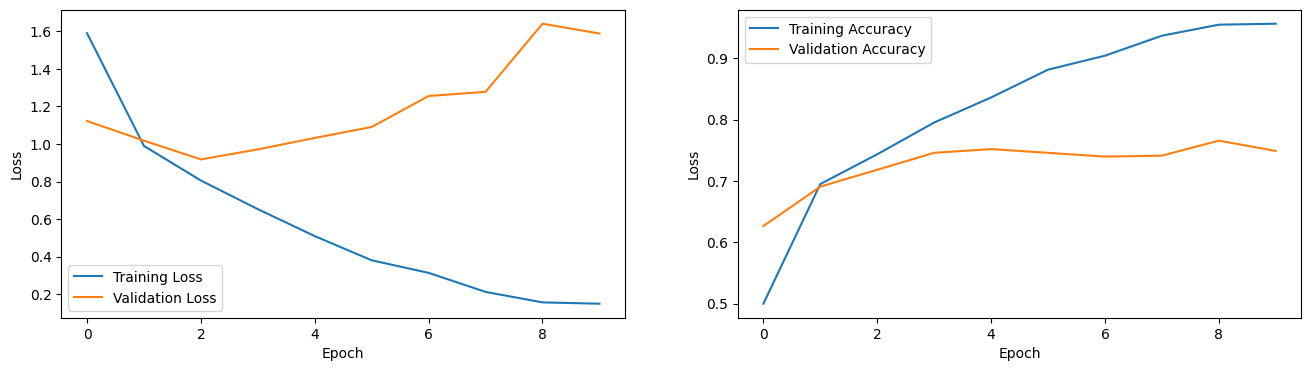

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_nums1.history['loss'], label='Training Loss')
plt.plot(history_nums1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_nums1.history['accuracy'], label='Training Accuracy')
plt.plot(history_nums1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Similar al primer modelo de clasificación de todas las cartas, se observa un overfitting muy evidente. Después de haber separado el problema de 53 clases en un problema de 5 clases y un problema de 14 clases, se podria decir que el desempeño del modelo de clasificación de todas las cartas se debe al componente de los números de las cartas, ya que en este modelo que solamente clasifica los números tiene un comportamiento similar; se tienen resultados de entrenamiento muy buenos, pero de validación malos.

A continuación, se evalúa el modelo con los datos de prueba.

In [ ]:
loss_ns1, accuracy_ns1 = model_nums1.evaluate(X_test_ns2, y_test_ns2)
print("Loss:", loss_ns1)
print("Accuracy:", accuracy_ns1)

51/51 [==============================] - 1s 22ms/step - loss: 1.7375 - accuracy: 0.7425
Loss: 1.7375324964523315
Accuracy: 0.7424892783164978


Los resultados de la evaluación son comparables con los de la validación de la última época de entrenamiento, confirmado el sobreajuste del modelo y la necesidad de hacer ajustes.

De todas formas, se guarda el modelo.

In [ ]:
# model_nums1.save("model_nums1.keras")

#### Ajuste del modelo

Siguiendo el mismo proceso que para los modelos anteriores, se le van a hacer modificaciones a la arquitectura del modelo para (con algo de suerte) obtener un mejor modelo. Igualmente se aplica Data Augmentation.

In [ ]:
data_augmentation = keras.Sequential([layers.RandomRotation(0.5, fill_mode="constant", fill_value=0.0)], name='data_augmentation')

Después de probar con algunas arquitecturas, el que se decidió mantener para la entrega tiene una capa menos de convolución, al igual que capas de convolución con menos filtros. Fuera de eso, se añaden capas de Batch Normalization y una de Dropout al final.

In [ ]:
model_nums2 = keras.Sequential([keras.Input(shape=(224, 224, 3)),
                          data_augmentation,
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
                          layers.BatchNormalization(),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.Dropout(0.1),
                          layers.Flatten(),
                          layers.Dense(14, activation="softmax")])

model_nums2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                      

Nuevamente se compila el modelo con los mismos parámetros que el primero

In [ ]:
model_nums2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Con las modificaciones realizadas, se asume que el overfitting será menor, por lo que se dejará correr por 25 épocas.

In [ ]:
history_nums2 = model_nums2.fit(X_train_ns2, y_train_ns2, epochs=25, validation_split=0.1)

Epoch 1/25
184/184 [==============================] - 24s 102ms/step - loss: 1.9018 - accuracy: 0.3961 - val_loss: 3.7871 - val_accuracy: 0.1026
Epoch 2/25
184/184 [==============================] - 18s 97ms/step - loss: 1.4713 - accuracy: 0.5193 - val_loss: 1.7092 - val_accuracy: 0.5191
Epoch 3/25
184/184 [==============================] - 18s 97ms/step - loss: 1.3398 - accuracy: 0.5719 - val_loss: 1.4226 - val_accuracy: 0.5666
Epoch 4/25
184/184 [==============================] - 18s 97ms/step - loss: 1.2509 - accuracy: 0.6029 - val_loss: 1.3727 - val_accuracy: 0.5850
Epoch 5/25
184/184 [==============================] - 18s 96ms/step - loss: 1.1968 - accuracy: 0.6281 - val_loss: 1.4811 - val_accuracy: 0.5436
Epoch 6/25
184/184 [==============================] - 18s 96ms/step - loss: 1.1265 - accuracy: 0.6494 - val_loss: 1.3395 - val_accuracy: 0.6279
Epoch 7/25
184/184 [==============================] - 18s 96ms/step - loss: 1.0890 - accuracy: 0.6588 - val_loss: 1.3497 - val_accuracy

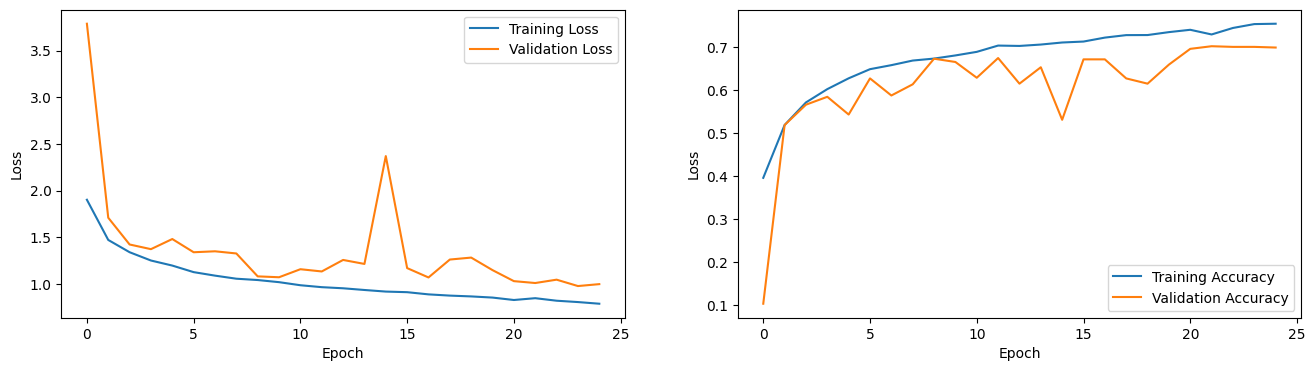

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history_nums2.history['loss'], label='Training Loss')
plt.plot(history_nums2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history_nums2.history['accuracy'], label='Training Accuracy')
plt.plot(history_nums2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Observando las gráficas de las métricas de este nuevo modelo, se nota que el sobreajuste ha disminuido bastante. Sin embargo, como ha sucedido con otros modelos, el accuracy en general también disminuyó un poco. El loss de entrenamiento aumentó, pero el de validación disminuyó en comparación con el primer modelo.<br>
Todavía hay un pequeño grado de overfitting, pero de todos modos ha mejorado.

Igual que el modelo principal, se evalúa el modelo modificado.

In [ ]:
loss_nums2, accuracy_nums2 = model_nums2.evaluate(X_test_ns2, y_test_ns2)
print("Loss:", loss_nums2)
print("Accuracy:", accuracy_nums2)

51/51 [==============================] - 1s 18ms/step - loss: 1.0044 - accuracy: 0.7204
Loss: 1.0043586492538452
Accuracy: 0.7204169034957886


Para este modelo, hay una diferencia pequeña en la métrica de accuracy a comparación del primer modelo, mientras que para la métrica de loss se percibe una mejora significante.

Finalmente, se guarda el modelo.

In [ ]:
# model_nums2.save("model_nums2.keras")

#### Predicciones de Números

(Se usa el <b>segundo</b> modelo para las predicciones de esta sección)

Se "invierte" el diccionario que relaciona números con las clases.

In [ ]:
card_type_labels = {}

for i in card_type_dict:
  card_type_labels[card_type_dict[i]] = i

card_type_labels

{0: 'joker',
 1: 'ace',
 2: 'two',
 3: 'three',
 4: 'four',
 5: 'five',
 6: 'six',
 7: 'seven',
 8: 'eight',
 9: 'nine',
 10: 'ten',
 11: 'jack',
 12: 'queen',
 13: 'king'}

La siguientes celdas solamente toman cartas al azar y tratan de clasificar el número.

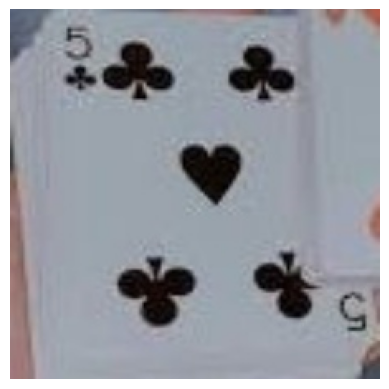

1/1 [==============================] - 0s 122ms/step
Suit Prediction:  five 0.95061135
Suit True Label:  five


In [ ]:
random_inx_ns = np.random.choice(X_test_ns.shape[0])
test_image_ns = X_test_ns2[random_inx_ns]
test_label_ns = y_test_ns2[random_inx_ns]

plt.axis('off')
plt.imshow(test_image_ns)
plt.show()

pred_card_t = model_nums2.predict(test_image_ns[np.newaxis,...])
print("Suit Prediction: ", card_type_labels[np.argmax(pred_card_t)], pred_card_t.max())
print("Suit True Label: ", card_type_labels[test_label_ns])

Para este ejemplo, sí se logró clasificar correctamente el 5. El 0.95 indica que de las opciones posibles, se estaba más seguro de que era un 5.

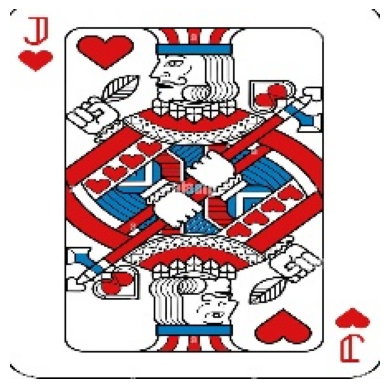

1/1 [==============================] - 0s 22ms/step
Suit Prediction:  king 0.8829585
Suit True Label:  jack


In [ ]:
random_inx_ns = np.random.choice(X_test_ns.shape[0])
test_image_ns = X_test_ns2[random_inx_ns]
test_label_ns = y_test_ns2[random_inx_ns]

plt.axis('off')
plt.imshow(test_image_ns)
plt.show()

pred_card_t = model_nums2.predict(test_image_ns[np.newaxis,...])
print("Suit Prediction: ", card_type_labels[np.argmax(pred_card_t)], pred_card_t.max())
print("Suit True Label: ", card_type_labels[test_label_ns])

Para este ejemplo, el modelo se confunde y clasifica una J como un Rey. Se me ocurre que esto sucede porque el modelo trató de aprenderse los dibujos y no lo que está en las esquinas de las cartas. Una posible solución sería aumentar el porcentaje de Dropout, para que el modelo no se enfoque tanto en la imagen y que trate de fijarse en las esquinas.

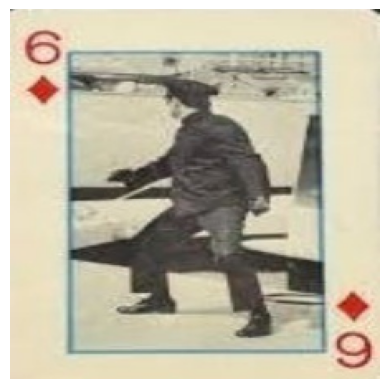

1/1 [==============================] - 0s 20ms/step
Suit Prediction:  four 0.43322602
Suit True Label:  six


In [ ]:
random_inx_ns = np.random.choice(X_test_ns.shape[0])
test_image_ns = X_test_ns2[random_inx_ns]
test_label_ns = y_test_ns2[random_inx_ns]

plt.axis('off')
plt.imshow(test_image_ns)
plt.show()

pred_card_t = model_nums2.predict(test_image_ns[np.newaxis,...])
print("Suit Prediction: ", card_type_labels[np.argmax(pred_card_t)], pred_card_t.max())
print("Suit True Label: ", card_type_labels[test_label_ns])

En este ejemplo se confunde una carta de un 6 con un 4. Lo único que se me ocurre es que la imagen de la carta causa que se confunda el modelo de alguna forma. Tal vez piensa que la pose de la persona en la imagen parece un 4 muy grande.

En general, las predicciones de los números no son muy buenas.

## Resultados

### Modelo de todas las cartas

En el primer modelo, se tenía un problema muy grande de overfitting; el modelo se aprendió muy bien el conjunto de datos de entrenamiento, a tal grado que no era capaz de generalizar. Para tratar de combatir esto, se realizó un poco de Data Augmentation, se añadieron capas de BatchNormalization, se añadió una capa de Dropout y se incrementó el número de épocas que se entrenaba el modelo.
<br><br>
El nuevo modelo tuvo un mejor resultado en términos de overfitting, ya que la diferencia entre los valores de accuracy para los datos de entrenamiento y para los datos de validación disminuyó bastante. Los valores de pérdida también bajaron mucho. Todo esto parecería indicar que se obtuvo un mejor modelo. Sin embargo, a pesar de que se haya arreglado un poco el problema de overfitting, los valores de accuracy del último modelo no son muy buenos, por lo que aunque se obtuvo un mejor modelo, no es necesariamente un buen modelo.
<br><br>
No obstante, no significa necesariamente que se tenga un mal modelo, sino que podría ser simplemente que faltan imágenes para entrenar mejor al modelo. Tomando en cuenta que se está trabajando con 53 clases distintas, es bastante posible que tener menos de 200 imágenes para cada clase no es suficiente para entrenar un buen modelo. Del mismo modo, se puede considerar que para cartas de palos diferentes, pero números iguales, no hay mucha diferencia en el contenido general de la carta (un 8 de diamantes y un 8 de corazones van a tener la misma cantidad de elementos, y su única diferencia es la forma de dichos elementos).

### Modelo de Palos

Debido al desempeño de los modelo de clasificación de las cartas individuales, se decidió hacer un modelo para el problema simplificado de la clasificación de solamente los palos. Habiendo usado la misma arquitectura que el primer modelo de todas las cartas, se obtuvieron resultados muy buenos, con un poco de overfitting, pero con métricas de accuracy y loss generalmente buenas. Se hicieron unas pequeñas modificaciones al modelo para tratar de hacer que fuera incluso mejor.<br><br>
El modelo modificado ayudó a cerrar la pequeña brecha entre los datos de entrenamiento y validación, mejorando el aspecto de overfitting. Sin embargo, el accuracy en general disminuyó un poco. A pesar de esto, sigue siendo un modelo de clasificación decente. Las métricas obtenidas al evaluar el modelo con los datos de prueba también fueron muy buenas.<br><br>
A pesar de haber obtenido muy buenos resultados con ambos modelos, siempre hay oportunidades de mejora, como en el caso de la carta con rotación que se clasificó mal. Una solución sería trabajar más con la parte de Data Augmentation para tener más imágenes de cartas con rotación para entrenar la red. También sería bueno (aunque tarde más tiempo) revisar manualmente las imágenes de las cartas para verificar que están guardadas en las carpetas con los labels correctos, ya que se identificaron algunas que parecían no estar colocadas correctamente.

### Modelo de Números

El desempeño del primer modelo de los números se parece al desempeño del primer modelo de las cartas individuales, en el sentido de que se tenía un modelo demasiado sobreajustado a los datos de entrenamiento. Incluso habiendo reducido el número de clases de 53 a 14, puede ser que todavía faltan imágenes de entrenamiento para que se puede tener un buen modelo que sea capaz de generalizar. Las métricas tanto de validación como de prueba indican que no se tiene como tal un mal modelo, pero definitivamente puede ser mejor.<br><br>
Para el segundo modelo, además de la adición de capas de Data Augmentation, Batch Normalization y Dropout, se hicieron pruebas aumentando el número de capas de convolución, pero terminó dando malos resultados. Por esta razón, se intentó reducir el número de capas de convolución, y fue el modelo que se terminó usando. Con las modificaciones realizadas, al evaluar el modelo se logró reducir la métrica de loss, mientras que la métrica de accuracy se mantuvo algo consistente comparado con la evaluación del primer modelo. En este modelo se logró mejorar el problema de overfitting sin perder demasiado en el accuracy, así que definitivamente se obtuvo un mejor modelo. Todavía se puede mejorar, pero a comparación del primero, no estuvo mal.<br><br>
Similar al modelo de las 53 clases, no se tiene un modelo perfecto, pero al mismo tiempo tampoco es horrible; considerando que tienen accuracy de más de 70%, se puede decir que es un modelo decente para clasificar los números de las cartas, siempre y cuando no estén muy estilizadas. Es posible que ajustando la capa de Dropout se consigan mejores resultados, pues podría ser que el modelo actual se enfoca más en las ilustraciones de las cartas que en los números o la cantidad de elementos que tiene; ajustar la capa de Dropout obligaría el modelo a generar nuevas conexiones y a determinar otras características de las cartas para clasificarlas.

## Predicciones "fáciles" de cartas

Para realizar predicciones de cartas fácilmente, se pueden ejecutar las siguientes celdas<br>
Hay que asegurarse de que los siguientes archivos estén en el directorio:
- kaggle.json
- model_all1.keras
- model_all2.keras
- model_suit1.keras
- model_suit2.keras
- model_nums1.keras
- model_nums2.keras

Primero se importan las librerías necesarias y se obtienen las imágenes de Kaggle

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/cards-image-datasetclassification
!unzip cards-image-datasetclassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/jack of spades/059.jpg  
  inflating: train/jack of spades/060.jpg  
  inflating: train/jack of spades/061.jpg  
  inflating: train/jack of spades/062.jpg  
  inflating: train/jack of spades/063.jpg  
  inflating: train/jack of spades/064.jpg  
  inflating: train/jack of spades/065.jpg  
  inflating: train/jack of spades/066.jpg  
  inflating: train/jack of spades/067.jpg  
  inflating: train/jack of spades/068.jpg  
  inflating: train/jack of spades/069.jpg  
  inflating: train/jack of spades/070.jpg  
  inflating: train/jack of spades/071.jpg  
  inflating: train/jack of spades/072.jpg  
  inflating: train/jack of spades/073.jpg  
  inflating: train/jack of spades/074.jpg  
  inflating: train/jack of spades/075.jpg  
  inflating: train/jack of spades/076.jpg  
  inflating: train/jack of spades/077.jpg  
  inflating: train/jack of spades/078.jpg  
  inflating: train/jack of spades/079.jpg  
  inflating: train/jack o

Se lee el archivo csv y se le hace un pequeño preprocesamiento

In [2]:
cards = pd.read_csv("cards.csv")

cards["card type"].replace("xxx", "joker", inplace=True)
cards["suit"] = cards["labels"].map(lambda x : x if x == "joker" else x[x.index("of")+3:])
cards.drop(120, inplace=True)
cards.reset_index(inplace=True, drop=True)

img_list = []

for path in cards["filepaths"]:
  im_temp = np.array(Image.open(path))
  img_list.append(im_temp)

cards["image"] = pd.DataFrame({"image":img_list})

Se generan los diccionarios con los labels

In [3]:
labels_all = [(idc, cards[cards["class index"] == idc]["labels"].head(1).values[0]) for idc in range(53)]

suit_dict = {"joker": 0,
             "clubs": 1,
             "hearts": 2,
             "spades": 3,
             "diamonds": 4}

card_type_dict = {"joker": 0,
                  "ace": 1,
                  "two": 2,
                  "three": 3,
                  "four": 4,
                  "five": 5,
                  "six": 6,
                  "seven": 7,
                  "eight": 8,
                  "nine": 9,
                  "ten": 10,
                  "jack": 11,
                  "queen": 12,
                  "king": 13}

suit_labels = {}
card_type_labels = {}

for i in suit_dict:
  suit_labels[suit_dict[i]] = i

for i in card_type_dict:
  card_type_labels[card_type_dict[i]] = i

Se dividen los datos en inputs y labels

In [4]:
X_predictions = cards["image"]
y_predictions_all = cards["class index"]
y_predictions_suit = cards["suit"]
y_predictions_nums = cards["card type"]

y_predictions_suit = y_predictions_suit.map(lambda x : suit_dict[x])
y_predictions_nums = y_predictions_nums.map(lambda x : card_type_dict[x])

X_predictions = np.array(X_predictions.to_list())
y_predictions_all = np.array(y_predictions_all)
y_predictions_suit = np.array(y_predictions_suit)
y_predictions_nums = np.array(y_predictions_nums)

Se cargan los modelos desde el directorio

In [5]:
model_all1 = keras.models.load_model("model_all1.keras")
model_all2 = keras.models.load_model("model_all2.keras")
model_suit1 = keras.models.load_model("model_suit1.keras")
model_suit2 = keras.models.load_model("model_suit2.keras")
model_nums1 = keras.models.load_model("model_nums1.keras")
model_nums2 = keras.models.load_model("model_nums2.keras")

Después de correr las celdas anteriores, es posible correr la siguientes celdas las veces deseadas para ver las imágenes y las predicciones de diferentes cartas aleatoriamente. Se ven las predicciones realizadas para cada problema, con ambos modelos generados. Es importante mencionar que se realizar predicciones con todo el conjunto de datos utilizado, por lo que es posible que se observe un sesgo hacia las imágenes con las que fueron entrenados los modelos.

### Cartas individuales

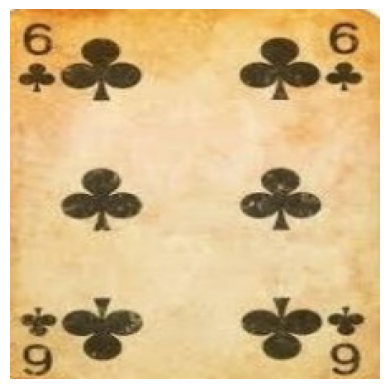

1/1 [==============================] - 0s 25ms/step

Con Modelo 1:
  Card Prediction:  (37, 'six of clubs') 1.0
Con Modelo 2:
  Card Prediction:  (37, 'six of clubs') 0.9995844

Card True Label:  (37, 'six of clubs')


In [21]:
random_inx_pred = np.random.choice(X_predictions.shape[0])
test_image = X_predictions[random_inx_pred]
test_label = y_predictions_all[random_inx_pred]

plt.axis('off')
plt.imshow(test_image)
plt.show()

pred_all1 = model_all1.predict(test_image[np.newaxis,...])
pred_all2 = model_all2.predict(test_image[np.newaxis,...])

print()
print("Con Modelo 1:")
print("  Card Prediction: ", labels_all[np.argmax(pred_all1)], pred_all1.max())
print("Con Modelo 2:")
print("  Card Prediction: ", labels_all[np.argmax(pred_all2)], pred_all2.max())
print()
print("Card True Label: ", labels_all[test_label])

### Palos de Cartas

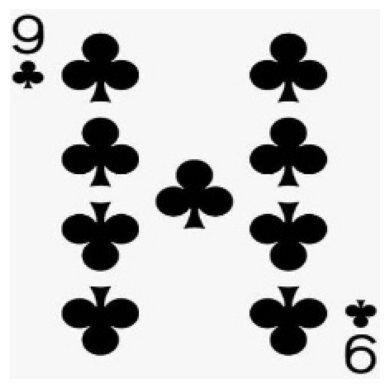

1/1 [==============================] - 0s 18ms/step

Con Modelo 1:
  Suit Prediction:  clubs 1.0
Con Modelo 2:
  Suit Prediction:  clubs 1.0

Suit True Label:  clubs


In [96]:
random_inx_pred = np.random.choice(X_predictions.shape[0])
test_image = X_predictions[random_inx_pred]
test_label = y_predictions_suit[random_inx_pred]

plt.axis('off')
plt.imshow(test_image)
plt.show()

pred_suit1 = model_suit1.predict(test_image[np.newaxis,...])
pred_suit2 = model_suit2.predict(test_image[np.newaxis,...])

print()
print("Con Modelo 1:")
print("  Suit Prediction: ", suit_labels[np.argmax(pred_suit1)], pred_suit1.max())
print("Con Modelo 2:")
print("  Suit Prediction: ", suit_labels[np.argmax(pred_suit2)], pred_suit2.max())
print()
print("Suit True Label: ", suit_labels[test_label])

### Números

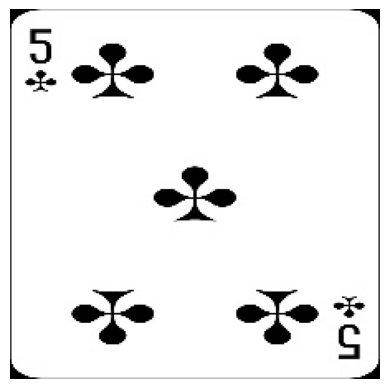

1/1 [==============================] - 0s 28ms/step

Con Modelo 1:
  Number Prediction:  five 1.0
Con Modelo 2:
  Number Prediction:  five 0.99920505

Number True Label:  five


In [89]:
random_inx_pred = np.random.choice(X_predictions.shape[0])
test_image = X_predictions[random_inx_pred]
test_label = y_predictions_nums[random_inx_pred]

plt.axis('off')
plt.imshow(test_image)
plt.show()

pred_nums1 = model_nums1.predict(test_image[np.newaxis,...])
pred_nums2 = model_nums2.predict(test_image[np.newaxis,...])

print()
print("Con Modelo 1:")
print("  Number Prediction: ", card_type_labels[np.argmax(pred_nums1)], pred_nums1.max())
print("Con Modelo 2:")
print("  Number Prediction: ", card_type_labels[np.argmax(pred_nums2)], pred_nums2.max())
print()
print("Number True Label: ", card_type_labels[test_label])

### Especificar una carta nueva

Para la parte de especificar una carta que no fue parte del dataset de entrenamiento y prueba, se utiliza el primer modelo generado para la clasificación de los palos, ya que fue el que mejor desempeño tuvo de todos los modelos. Simplemente hay que incluir la imagen en el directorio y especificar su nombre.

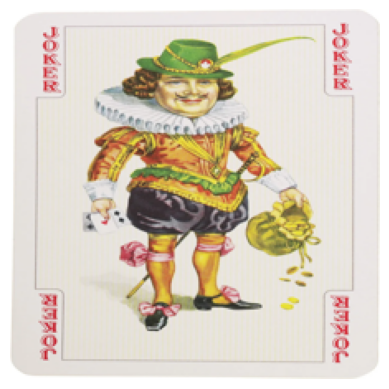

1/1 [==============================] - 0s 29ms/step

Suit Prediction:  joker 0.99835557


In [101]:
nombre_imagen = "joker_test.webp"
test_image = Image.open(nombre_imagen)

test_image = np.array(test_image.resize((224, 224)))

plt.axis('off')
plt.imshow(test_image)
plt.show()

pred_new_im = model_suit1.predict(test_image[np.newaxis,...])

print()
print("Suit Prediction: ", suit_labels[np.argmax(pred_new_im)], pred_new_im.max())

## Reflexiones

Después de haber recibido retroalimentación en la primera entrega, se tomó la decisión de separar el problema original en 2 problemas más pequeños, pero manteniendo lo que se hizo originalmente. Para la clasificación de los palos de las cartas, esto funcionó muy bien, ya que se lograron obtener resultados muy buenos desde el primer modelo generado, logrando alcanzar una precisión de más de 90%. Por otra parte, la solución del problema de la clasificación de los números no fue igual de buena, ya que se logró un desempeño similar al observado para el modelo de todas las cartas. Esto me hace pensar que la razón por la que el modelo de las cartas individuales no es muy bueno es precisamente por el componente de los números.<br><br>
En retrospectiva, hay varias cosas que se pudieron haber hecho si se hubiera tenido más tiempo y no hubieran límites tanto en el uso del GPU como de la RAM de Google Colab. Se hubiera experimentado más con diferentes capas o con diferentes números de filtros para tratar de obtener mejores modelos. También se hubiera tratado de entrenar los modelos por más épocas, pero precisamente como hay restricciones en el uso del GPU no se exploró mucho la idea.<br><br>
De igual forma, hubiera sido muy interesante haber logrado generar un solo modelo con 2 salidas; intenté hacerlo con un modelo que no fuera secuencial, pasándole los labels del palo de la carta y el número, pero me acababa saliendo un error que simplemente no lograba resolver. Por esta razón (y por cuestiones de tiempo) decidí mejor hacer 2 modelos por separado.<br><br>
También, sería bueno tratar de ampliar el dataset, ya que para el entrenamiento de los modelos actuales se tienen muchas cartas estilizadas que pueden llegar a confundir el modelo. Esto, junto con una revisión del dataset para confirmar que cada carta tenga el label correcto, debería mejorar la clasificación en los 3 problemas.

## Conclusiones

Para concluir, se hicieron 6 modelos en total, con enfoques diferentes del mismo problema de clasificación de cartas. Los 6 modelos surgieron a partir de hacer 2 modelos por cada uno de los 3 enfoques.<br><br>
Finalmente, considero que para el problema de las cartas individuales y el problema de la clasificación de números, se puede argumentar que los segundos modelos son mejores que los primeros porque ayudan con el overfitting y reducen la métrica de loss, aunque tal vez no mejore el accuracy general. Por otra parte, para el problema de los palos, considero que el mejor modelo fue el primero que se obtuvo, ya que tiene muy poco overfitting (comparado con los otros problemas) y mejores métricas de evaluación que el segundo modelo generado.<br><br>
A lo largo del proceso de desarrollo de la actividad, logré comprender la importancia de tener acceso a GPUs; reducen mucho el tiempo de cómputo y permiten hacer más experimentos. Luego, como todo esto se está haciendo en Google Colab, hay límites a la cantidad de GPU que se puede utilizar por usuario, por lo que en una ocasión tuve que cambiar de cuenta para continuar entrenando los modelos rápidamente. También aprendí sobre la importancia de tener una métrica de pérdida adecuada en el compilador del modelo, ya que al principio simplemente había colocado <code>categorical_crossentropy</code> y cada vez que trataba de empezar a entrenar el modelo marcaba un error que mencionaba las dimensiones de los inputs y los outputs. No fue hasta que lo cambié a <code>sparse_categorical_crossentropy</code> que por fin empezó a correr bien. Revisar la documentación de las capas para hacer Data Augmentation también fue útil, ya que pude ver si había más capas que podría usar para aumentar los datos y los diferentes hiperparámetros que se podían ajustar.<br><br>
Otro aspecto interesante del proyecto la cantidad de clases que se tenían. Al principio eran 53, muchas más de las que había trabajado antes. Considero que para la cantidad de clases y la cantidad de imágenes para cada clase, los modelos obtenidos no son completamente malos. Siempre hay áreas de mejora, y para este problema en particular puede que lo que más ayudaría a los modelos es tener más datos de entrenamiento.<br><br>
De manera más general, la actividad fue una experiencia bastante interesante, averiguando a entrenar una red neuronal y proponiendo maneras de mejorarlo me ayudó a puntualizar en los temas vistos en clase. Y aunque no se haya logrado realizar el modelo con las 2 salidas para la entrega, me deja con la curiosidad de seguir intentando.